## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [0]:
import os
import keras

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
sbonly = [True, False]

In [29]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

results = {}
for sb in sbonly:
    print("save_best_only: %s" % (sb))
    model_ckpt = ModelCheckpoint(filepath="./tmp.h5", monitor="val_loss", save_best_only=sb)
    model = build_mlp(input_shape=x_train.shape[1:])
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True,
              callbacks=[model_ckpt])
    
    # Load back
    loadbackmodel = keras.models.load_model("./tmp.h5")
    loss_loadback, acc_loadback = loadbackmodel.evaluate(x_test, y_test)
    
    # Collect results
    exp_name_tag = ("save_best_only: %s" % (sb))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'test-loss': loss_loadback,
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"],
                             'test-acc': acc_loadback}
    


save_best_only: True
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.2016 - acc: 0.2772 - val_loss: 2.0864 - val_acc: 0.3337
Epoch 2/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.7338 - acc: 0.3983 - val_loss: 1.8488 - val_acc: 0.3818
Epoch 3/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.6093 - acc: 0.4378 - val_loss: 1.6890 - val_acc: 0.4102
Epoch 4/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.5377 - acc: 0.4625 - val_loss: 1.6292 - val_acc: 0.4263
Epoch 5/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.4826 - acc: 0.4833 - val_loss: 1.5984 - val_acc: 0.4361
Epoch 6/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.4388 - acc: 0.4999 - val_loss: 1.5601 - val_acc: 0.4483
Epoch 7/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.4019 - acc: 0.5131 - val_l

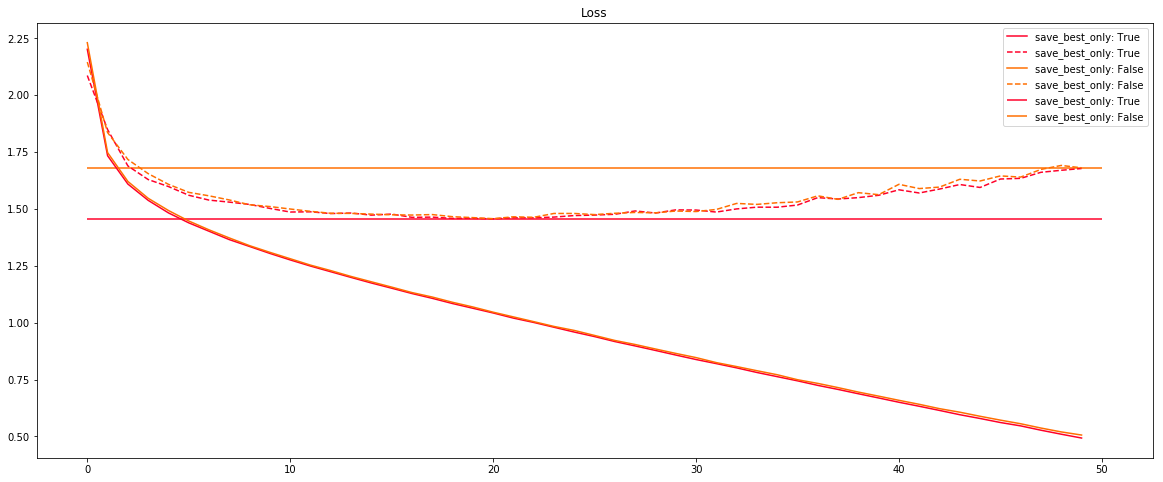

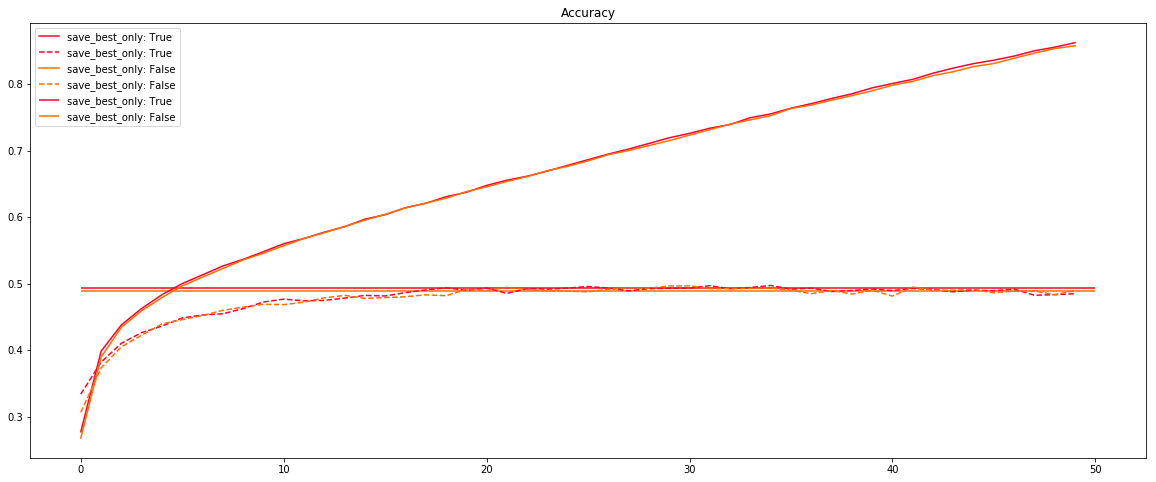

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 10

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(20,8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['test-loss'], xmin=0, xmax=len(results[cond]['train-loss']), label=cond, color=color_bar[i], linestyles='-')
plt.title("Loss")
plt.legend();

plt.figure(figsize=(20,8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['test-acc'], xmin=0, xmax=len(results[cond]['train-acc']), label=cond, color=color_bar[i], linestyles='-')
plt.title("Accuracy")
plt.legend();